<a href="https://colab.research.google.com/github/mdjamina/machine_learning/blob/notebook/notebook/deft09_parlement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from pathlib import Path
import re
import pandas as pd

# Rapport d'analyse des données

## Corpus

## Prétraitement des données

### Corpus d'apprentissage

In [3]:
data_dir = '/content/'
train_file_path = data_dir + 'deft09_parlement_appr_fr.xml'
tests_file_path = data_dir +'deft09_parlement_test_fr.xml'
ref_file_path = data_dir +'deft09_parlement_ref_fr.txt'


### Nettoyage des données

In [7]:

# Remplacer les caractères spéciaux
# cette permet de remplacer les caractères spéciaux


def replace_match(match: re.Match) -> str:

    char = match.group(0)
    replacements = {'<anonyme />':'ANONYME','’': "'",'´': "'",'`': "'",'‘': "'",'«': '"','»': '"','“': '"','”': '"','–': '-','—': '-','…': ' ',u'\xa0': ' ',}

    return replacements[char]



#### corpus d'apprentissage

In [8]:
#Corriger le fichier train
pathfile = Path(train_file_path)
if not pathfile.exists():
    raise FileNotFoundError(f"{pathfile} not found")

pathfile_fix = pathfile.parent / f"{pathfile.stem}_fix{pathfile.suffix}"

with pathfile.open('r') as f:
    pattern = re.compile(r'<anonyme\s*/>|[’´`‘«»“”–—…]')
    content = re.sub(pattern, replace_match, f.read()).strip()
    with pathfile_fix.open('w') as f2:
        f2.write(content)
train_file_path = str(pathfile_fix)
print(train_file_path)

/content/deft09_parlement_appr_fr_fix.xml


#### corpus de test

In [9]:
#Corriger le fichier test
pathfile = Path(tests_file_path)
if not pathfile.exists():
    raise FileNotFoundError(f"{pathfile} not found")

pathfile_fix = pathfile.parent / f"{pathfile.stem}_fix{pathfile.suffix}"

with pathfile.open('r') as f:
    pattern = re.compile(r'<anonyme\s*/>|[’´`‘«»“”–—…]')
    content = re.sub(pattern, replace_match, f.read()).strip()
    with pathfile_fix.open('w') as f2:
        f2.write(content)
tests_file_path = str(pathfile_fix)
print(tests_file_path)


/content/deft09_parlement_test_fr_fix.xml


### Chargement des données

In [10]:
from lxml import etree as et

#Parser le fichier xml
def parser(pathfile: str) -> list:

    # Parser le fichier XML avec lxml pour plus de performance
    tree = et.parse(pathfile)

    # Récupérer la racine du fichier XML
    root = tree.getroot()

    # Utiliser tqdm pour afficher la barre de progression
    for doc in root.findall('.//doc'):
        id_doc: str = doc.attrib['id']
        parti = None
        if doc.find('.//PARTI') is not None:
            parti = doc.find('.//PARTI').attrib['valeur']
        text = " ".join(p.text for p in doc.findall('.//p') if p.text)

        yield id_doc, parti, text


#### corpus d'apprentissage


In [11]:

data_train = pd.DataFrame(parser(str(train_file_path)), columns=['id', 'parti', 'text'])
data_train.head()

,id,parti,text
0,2_fr:1,Verts-ALE,"Monsieur le Président, j'ai toujours fait preu..."
1,2_fr:2,PPE-DE,"Madame la Présidente, chers collègues, à l'app..."
2,2_fr:3,Verts-ALE,"Je voudrais savoir si l'Union européenne, à la..."
3,2_fr:4,PSE,"Madame la Présidente, au nom des ANONYME de la..."
4,2_fr:5,PSE,"Monsieur le Président, chers collègues, Monsie..."


#### Corpus de test

In [12]:
data_tests = pd.DataFrame([(id_doc,text) for id_doc,_,text in parser(str(tests_file_path))], columns=['index', 'text'])
data_tests = data_tests.set_index('index')

data_tests.head()

,text
index,
1,"Monsieur le Président, l'accès à des médias li..."
2,"Monsieur le Président, j'ai un point de vue di..."
3,"Monsieur le Président, Monsieur le Commissaire..."
4,Nous ne pouvons soutenir cette tentative d'éri...
5,"Monsieur le Président, ce court débat se dérou..."


#### Données références

In [13]:
data_ref = pd.read_csv(ref_file_path, sep='\t', header=None, names=['index', 'parti'])
data_ref = data_ref.set_index('index')

data_ref.head()

,parti
index,
1,ELDR
2,GUE-NGL
3,PPE-DE
4,GUE-NGL
5,PPE-DE


### Prétraitement des données

#### chargement du modèle spacy

#### Prérequis

* installation des packages

```bash
pip install spacy
```    

* téléchargement du modèle

```bash
python -m spacy download fr_core_news_lg
```

In [ ]:
!python -m spacy download fr_core_news_lg

In [16]:
import spacy

disable = ["vectors", "senter", "textcat"]

nlp = spacy.load('fr_core_news_lg', disable=disable)

nlp.pipe_names

['tok2vec', 'morphologizer', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']

In [17]:

from spacy.lang.fr.stop_words import STOP_WORDS

def lemmatization(text: str, stop_words=True, pos:list = None) -> list:

    #doc = nlp(text)

    document = []

    for token in nlp(text):
        is_stop= any([token.lemma_ in STOP_WORDS,
                       token.text in STOP_WORDS,
                       token.is_stop,
                       token.is_punct,
                       token.is_space,
                       token.is_digit
                       ])
        if ( stop_words and is_stop):
            continue
        if pos and token.pos_ not in pos:
            continue
        document.append(token.lemma_.lower())

    # return document, entities
    return " ".join(document)


In [18]:
lemmatization(data_train['text'][0],pos=['VERB'])[:100]

'encourager permettre éviter pouvoir soutenir répondre soulever exprimer soumettre voir retarder devo'

## Entraînement du modèle

#### corpus d'apprentissage

In [45]:
y_train = data_train['parti'].to_numpy()
y_train[:5]

array(['Verts-ALE', 'PPE-DE', 'Verts-ALE', 'PSE', 'PSE'], dtype=object)

In [ ]:
x_train = data_train['text'].apply(lambda x: lemmatization(x)).to_numpy()


In [62]:
x_train[:3]

array(["monsieur président preuve scepticisme comportement moraliste policier encourager carrément délation permettre éviter fraude biais création instrument contrôle envahissant rapport pouvoir certainement groupe soutenir conviction rapport président napolitano modification règlement proposition décision répondre sérieusement préoccupation soulever récemment dell' alba dernier exprimer soumettre député contrôle excessif arbitraire voir aucun raison retarder davantage décision abus devoir produire parlement européen député disposer large possibilité défendre procédure interne transparent clair évidemment chose facile devoir confiance travail futur olaf devoir faciliter action manière pouvoir réagir crédible instrumentalisation pouvoir faire preuve efficacité agir répondre genre situation aujourd'hui theato bösch",
       'monsieur président cher collègue approche moment sombre année réjouissant évoquer heure vouloir attirer attention rituel réglage montre répéter printemps automne uti

#### Modèle de classification

In [46]:
from joblib import Memory
mem = Memory(location="/tmp/cachedir", verbose=1)

In [72]:
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline


tTfidVec = ('TfidfVectorizer', TfidfVectorizer(lowercase=False, max_df=0.95, min_df=10,sublinear_tf=True))

pipelines = {
    'LinearSVC': Pipeline([tTfidVec, ('LinearSVC', LinearSVC(max_iter=10000)) ])
    ,'MultinomialNB' :Pipeline([tTfidVec,('MultinomialNB', MultinomialNB()) ])
    , 'DecisionTreeClassifier': Pipeline([tTfidVec,('DecisionTreeClassifier', DecisionTreeClassifier()) ])
    , 'RandomForestClassifier': Pipeline([tTfidVec,('RandomForestClassifier', RandomForestClassifier()) ])

}


models = {}
for title,clf in pipelines.items():
  model = clf.fit(x_train, y_train)
  models[title] = model

#### entrainement du modèle

In [73]:

# Sauvegarder les modèles
from joblib import dump, load
for title, model in models.items():
    dump(model, f'{title}.joblib')



In [ ]:
# Charger les modèles
models = {}
for title in pipelines.keys():
    models[title] = load(f'{title}.joblib')
    
models.keys()

## Évaluation du modèle

In [76]:
x_test = data_tests['text'].apply(lambda x: lemmatization(x)).to_numpy()
y_test = data_ref['parti'].to_numpy()

In [ ]:
from sklearn import metrics

for title, model in models.items():
    predictions = model.predict(x_test)
    print(title)
    print(metrics.classification_report(y_test, predictions, output_dict=False))
    print('confusion_matrix')
    print(metrics.confusion_matrix(y_test, predictions))
    print('accuracy_score')
    print(metrics.accuracy_score(y_test, predictions))
    print('precision_score')
    print(metrics.precision_score(y_test, predictions, average='macro'))
    print('recall_score')
    print(metrics.recall_score(y_test, predictions, average='macro'))
    print('f1_score')
    print(metrics.f1_score(y_test, predictions, average='macro'))


### affichage des résultats



In [67]:
x_test[:1]

array(["Monsieur le Président, l'accès à des médias libres dans un débat ouvert et libre est l'une des pierres angulaires d'une société libre et démocratique. Les dictateurs de par le monde l'ont toujours su. Toutes les sociétés, tous les États qui répriment leur propre presse ne recherchent qu'une seule chose : faire taire le débat et asphyxier la démocratie, la communication ouverte et libre. Cela se manifeste tous les jours en Serbie. Les quelques stations de télévision et de radios indépendantes serbes subissent des tracasseries et sont pourchassées, pour finir par être totalement fermées. M. Milosevic menace le Monténégro, il s'en prend à la faible opposition serbe, il s'infiltre au Kosovo. M. Milosevic et ses complices doivent s'en aller, la démocratie doit être sauvegardée. Je voudrais dès lors poser une question au commissaire Nielson. Que fait-il et que fait l'UE pour faire en sorte que M. Milosevic soit traduit en justice devant la Cour internationale de justice de La Haye. C

In [69]:
y_test[:3]

array(['ELDR', 'GUE-NGL', 'PPE-DE'], dtype=object)

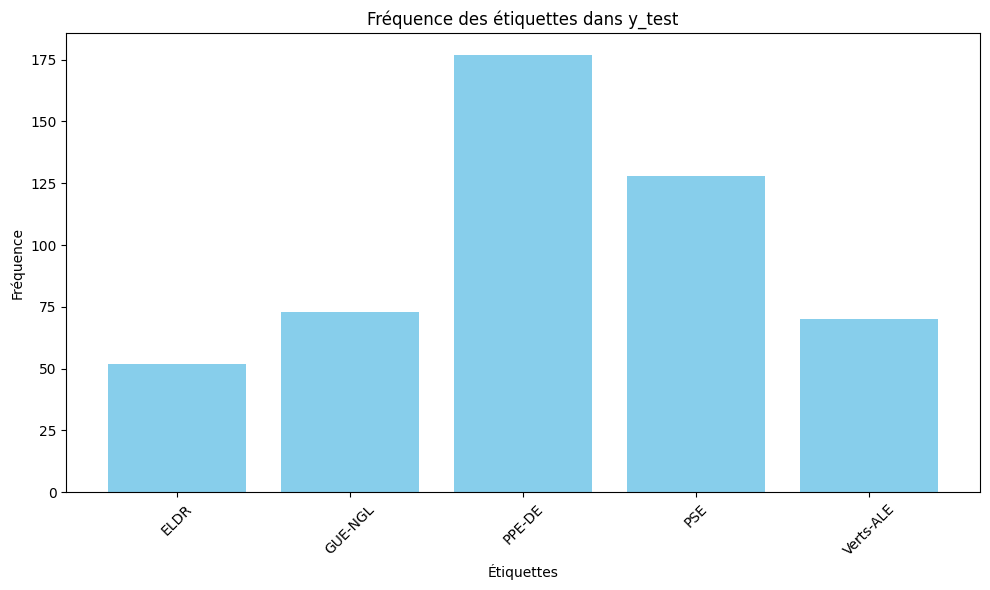

In [77]:
import matplotlib.pyplot as plt
import numpy as np



# Compter la fréquence de chaque étiquette
labels, counts = np.unique(y_test, return_counts=True)

# Création du graphique à barres
plt.figure(figsize=(10, 6))
plt.bar(labels, counts, color='skyblue')

# Ajout des titres et des labels
plt.title('Fréquence des étiquettes dans y_test')
plt.xlabel('Étiquettes')
plt.ylabel('Fréquence')
plt.xticks(rotation=45)  # Rotation des étiquettes de l'axe des x pour une meilleure lisibilité

# Affichage du graphique
plt.tight_layout()  # Ajuste automatiquement les paramètres pour que tout soit bien ajusté dans la figure
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


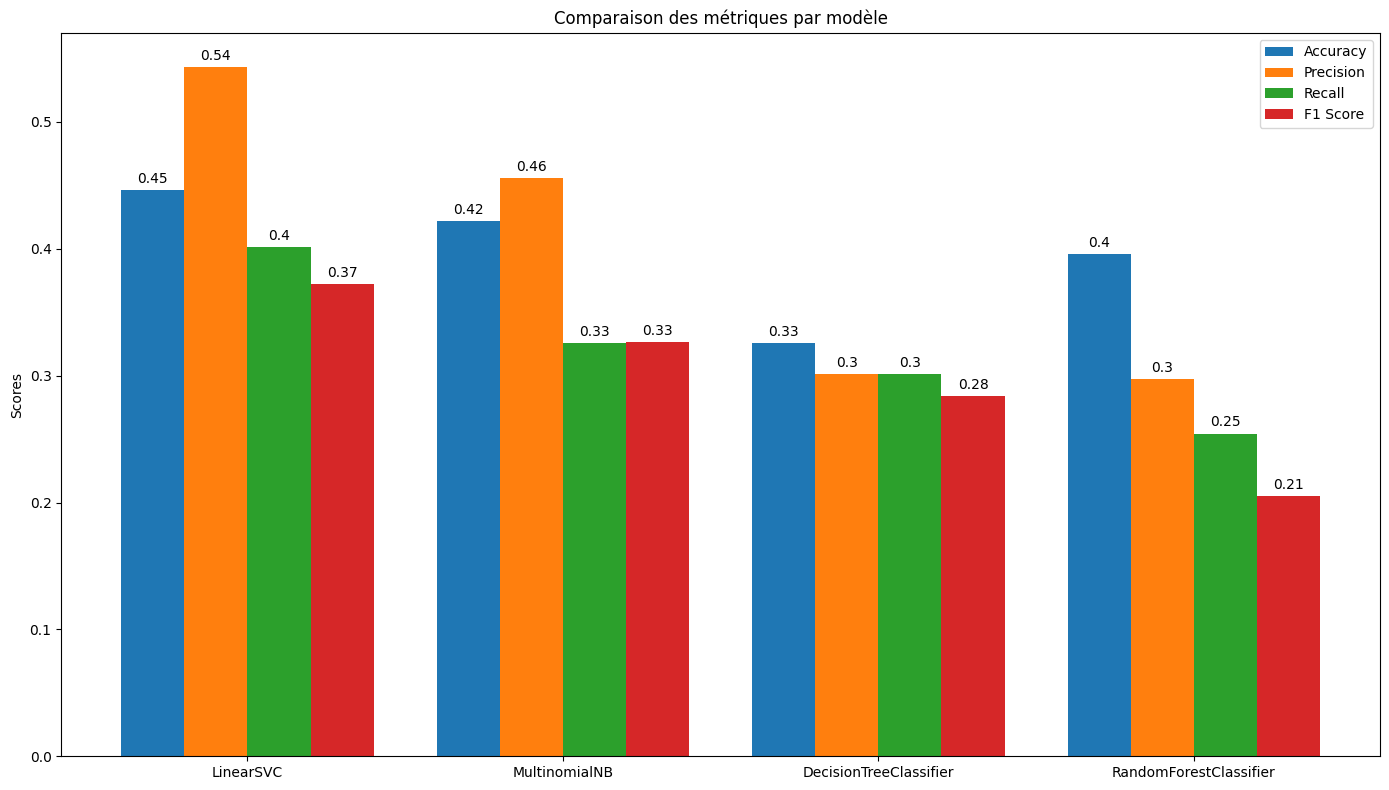

In [78]:
from sklearn import metrics
import matplotlib.pyplot as plt


# Initialisation d'un dictionnaire pour stocker les métriques pour chaque modèle
model_metrics = {}

# Calcul des métriques pour chaque modèle
for title, model in models.items():
    predictions = model.predict(x_test)
    model_metrics[title] = {
        'accuracy': metrics.accuracy_score(y_test, predictions),
        'precision': metrics.precision_score(y_test, predictions, average='macro'),
        'recall': metrics.recall_score(y_test, predictions, average='macro'),
        'f1': metrics.f1_score(y_test, predictions, average='macro')
    }

# Fonction pour tracer les graphiques à barres pour chaque métrique
def plot_metric_comparison(metrics_dict):
    labels = list(metrics_dict.keys())
    accuracy_scores = [m['accuracy'] for m in metrics_dict.values()]
    precision_scores = [m['precision'] for m in metrics_dict.values()]
    recall_scores = [m['recall'] for m in metrics_dict.values()]
    f1_scores = [m['f1'] for m in metrics_dict.values()]

    x = np.arange(len(labels))  # localisation des labels
    width = 0.2  # largeur des barres

    fig, ax = plt.subplots(figsize=(14, 8))

    # Création des barres pour chaque métrique
    rects1 = ax.bar(x - width*1.5, accuracy_scores, width, label='Accuracy')
    rects2 = ax.bar(x - width/2, precision_scores, width, label='Precision')
    rects3 = ax.bar(x + width/2, recall_scores, width, label='Recall')
    rects4 = ax.bar(x + width*1.5, f1_scores, width, label='F1 Score')

    # Ajout de textes pour les labels, titre et axes personnalisés
    ax.set_ylabel('Scores')
    ax.set_title('Comparaison des métriques par modèle')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    # Fonction pour attacher une étiquette au-dessus de chaque barre
    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(round(height, 2)),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    # Attacher les étiquettes
    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)
    autolabel(rects4)

    fig.tight_layout()

    plt.show()

# Appel de la fonction avec le dictionnaire de métriques
plot_metric_comparison(model_metrics)


